In [1]:
!apt install tesseract-ocr -y
!pip install pytesseract matplotlib seaborn Levenshtein


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 129 not upgraded.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.5/161.5 kB 4.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 60.2 MB/s eta 0:00:00:00:01


In [2]:
!wget http://cvit.iiit.ac.in/images/Projects/SceneTextUnderstanding/IIIT5K-Word_V3.0.tar.gz
!tar -xvzf IIIT5K-Word_V3.0.tar.gz


--2025-03-15 19:00:56--  http://cvit.iiit.ac.in/images/Projects/SceneTextUnderstanding/IIIT5K-Word_V3.0.tar.gz
Resolving cvit.iiit.ac.in (cvit.iiit.ac.in)... 196.12.53.50
Connecting to cvit.iiit.ac.in (cvit.iiit.ac.in)|196.12.53.50|:80... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: http://cdn.iiit.ac.in/cdn/cvit.iiit.ac.in/images/Projects/SceneTextUnderstanding/IIIT5K-Word_V3.0.tar.gz [following]
--2025-03-15 19:00:56--  http://cdn.iiit.ac.in/cdn/cvit.iiit.ac.in/images/Projects/SceneTextUnderstanding/IIIT5K-Word_V3.0.tar.gz
Resolving cdn.iiit.ac.in (cdn.iiit.ac.in)... 14.139.82.19
Connecting to cdn.iiit.ac.in (cdn.iiit.ac.in)|14.139.82.19|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 105861943 (101M) [application/octet-stream]
Saving to: ‘IIIT5K-Word_V3.0.tar.gz’

IIIT5K-Word_V3.0.ta 100%[===================>] 100.96M  9.65MB/s    in 12s     

2025-03-15 19:01:09 (8.77 MB/s) - ‘IIIT5K-Word_V3.0.tar.gz’ saved [105861943/1

In [4]:
import scipy.io

# Load the dataset metadata
data = scipy.io.loadmat("IIIT5K/testdata.mat")

# Check available keys in the dataset
print(data.keys())


dict_keys(['__header__', '__version__', '__globals__', 'testdata'])


In [5]:
print(data["testdata"])


[[(array(['test/1002_1.png'], dtype='<U15'), array(['PRIVATE'], dtype='<U7'), array([[array(['PRIVATE'], dtype='<U7'), array(['136'], dtype='<U3'),
          array(['17'], dtype='<U2'), array(['3SIDED'], dtype='<U6'),
          array(['55496002'], dtype='<U8'), array(['97'], dtype='<U2'),
          array(['ARCHANA'], dtype='<U7'), array(['AXELROD'], dtype='<U7'),
          array(['BANKS'], dtype='<U5'), array(['BLOOMERS'], dtype='<U8'),
          array(['BROOK'], dtype='<U5'), array(['CATHEDRAL'], dtype='<U9'),
          array(['CHANDIGARH'], dtype='<U10'),
          array(['CODE'], dtype='<U4'), array(['COLD'], dtype='<U4'),
          array(['DIVIDE'], dtype='<U6'), array(['ENOUGH'], dtype='<U6'),
          array(['EXTRA'], dtype='<U5'), array(['FARM'], dtype='<U4'),
          array(['FRIENDS'], dtype='<U7'), array(['FULLER'], dtype='<U6'),
          array(['GREAT'], dtype='<U5'), array(['HANTECH'], dtype='<U7'),
          array(['IRON'], dtype='<U4'), array(['KINGS'], dtype='<U5'),
 

In [7]:
import scipy.io
import numpy as np

# Load dataset metadata
data = scipy.io.loadmat("IIIT5K/testdata.mat")

# Extract image filenames & ground truth labels
image_filenames = []
ground_truths = []

for entry in data["testdata"][0]:  # Iterate through each entry
    img_path = "IIIT5K/" + entry[0][0]  # Extract image path
    label = entry[1][0]  # Extract ground truth label
    
    image_filenames.append(img_path)
    ground_truths.append(label)

# Convert to NumPy arrays for better handling
image_filenames = np.array(image_filenames)
ground_truths = np.array(ground_truths)

# Limit dataset to first 50 images for faster testing
image_filenames = image_filenames[:50]
ground_truths = ground_truths[:50]

# Print first 5 samples
for i in range(5):
    print(f"Image: {image_filenames[i]}, Ground Truth: {ground_truths[i]}")


Image: IIIT5K/test/1002_1.png, Ground Truth: PRIVATE
Image: IIIT5K/test/1002_2.png, Ground Truth: PARKING
Image: IIIT5K/test/1009_1.png, Ground Truth: SALUTES
Image: IIIT5K/test/100_1.png, Ground Truth: DOLCE
Image: IIIT5K/test/100_2.png, Ground Truth: GABBANA


In [8]:
import cv2
import pytesseract
import time
import Levenshtein  # For Word Error Rate (WER) and Character Error Rate (CER)

# Define Word Error Rate (WER) function
def word_error_rate(gt_text, pred_text):
    return Levenshtein.distance(gt_text, pred_text) / max(len(gt_text.split()), 1)

# Define Character Error Rate (CER) function
def char_error_rate(gt_text, pred_text):
    return Levenshtein.distance(gt_text, pred_text) / max(len(gt_text), 1)

# Function to evaluate OCR performance
def evaluate_tesseract(image_paths, ground_truths):
    wer_scores = []
    cer_scores = []
    processing_times = []

    for img_path, gt_text in zip(image_paths, ground_truths):
        img = cv2.imread(img_path)

        start_time = time.time()
        extracted_text = pytesseract.image_to_string(img).strip()
        end_time = time.time()

        processing_time = end_time - start_time
        processing_times.append(processing_time)

        wer_scores.append(word_error_rate(gt_text, extracted_text))
        cer_scores.append(char_error_rate(gt_text, extracted_text))

        print(f"GT: {gt_text} | OCR: {extracted_text} | WER: {wer_scores[-1]:.2f} | CER: {cer_scores[-1]:.2f}")

    return wer_scores, cer_scores, processing_times

# Run evaluation on the first 50 images
wer_scores, cer_scores, processing_times = evaluate_tesseract(image_filenames, ground_truths)


GT: PRIVATE | OCR:  | WER: 7.00 | CER: 1.00
GT: PARKING | OCR:  | WER: 7.00 | CER: 1.00
GT: SALUTES | OCR: Salutes | WER: 6.00 | CER: 0.86
GT: DOLCE | OCR: DOLCE | WER: 0.00 | CER: 0.00
GT: GABBANA | OCR:  | WER: 7.00 | CER: 1.00
GT: REGENCY | OCR: RE GENCY | WER: 1.00 | CER: 0.14
GT: STATE | OCR: STATE | WER: 0.00 | CER: 0.00
GT: BANK | OCR:  | WER: 4.00 | CER: 1.00
GT: OF | OCR:  | WER: 2.00 | CER: 1.00
GT: INDIA | OCR:  | WER: 5.00 | CER: 1.00
GT: KINGFISHER | OCR: KUNGEISHER. | WER: 3.00 | CER: 0.30
GT: CLEAR | OCR:  | WER: 5.00 | CER: 1.00
GT: CHANNEL | OCR: CHANNEL, | WER: 1.00 | CER: 0.14
GT: UNIVERSAL | OCR: AAs | WER: 8.00 | CER: 0.89
GT: STUDIOS | OCR: Cee | WER: 7.00 | CER: 1.00
GT: HOLLYWOOD | OCR: Tea Akh dee | WER: 11.00 | CER: 1.22
GT: COM | OCR: COM | WER: 0.00 | CER: 0.00
GT: LOAN | OCR: oan | WER: 4.00 | CER: 1.00
GT: THAT | OCR: that | WER: 4.00 | CER: 1.00
GT: HOME | OCR:  | WER: 4.00 | CER: 1.00
GT: LOANS | OCR:  | WER: 5.00 | CER: 1.00
GT: JAMMU | OCR:  | WER: 5.0

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


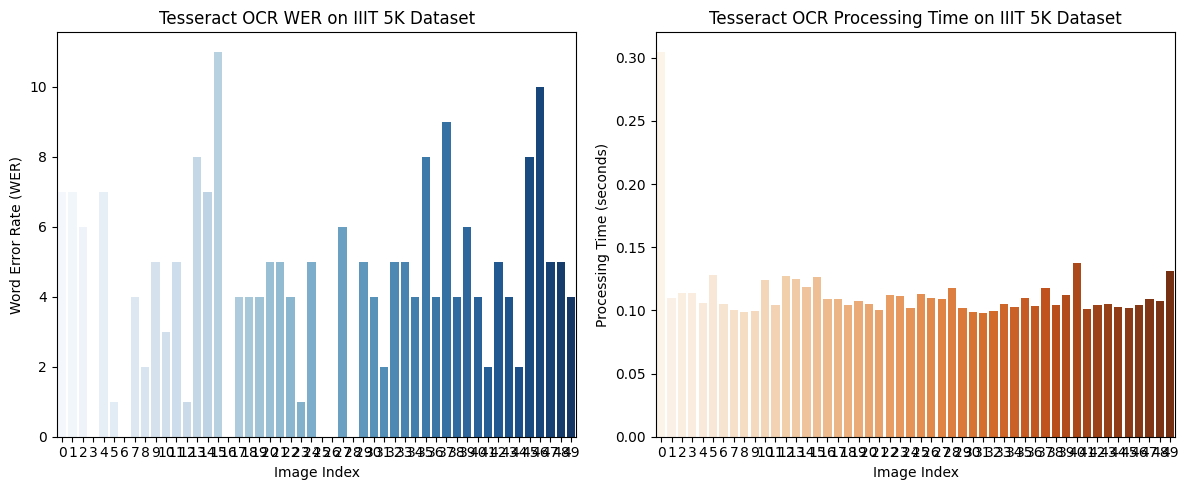

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))

# WER Graph
plt.subplot(1, 2, 1)
sns.barplot(x=list(range(len(wer_scores))), y=wer_scores, palette="Blues")
plt.xlabel("Image Index")
plt.ylabel("Word Error Rate (WER)")
plt.title("Tesseract OCR WER on IIIT 5K Dataset")

# Processing Time Graph
plt.subplot(1, 2, 2)
sns.barplot(x=list(range(len(processing_times))), y=processing_times, palette="Oranges")
plt.xlabel("Image Index")
plt.ylabel("Processing Time (seconds)")
plt.title("Tesseract OCR Processing Time on IIIT 5K Dataset")

plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


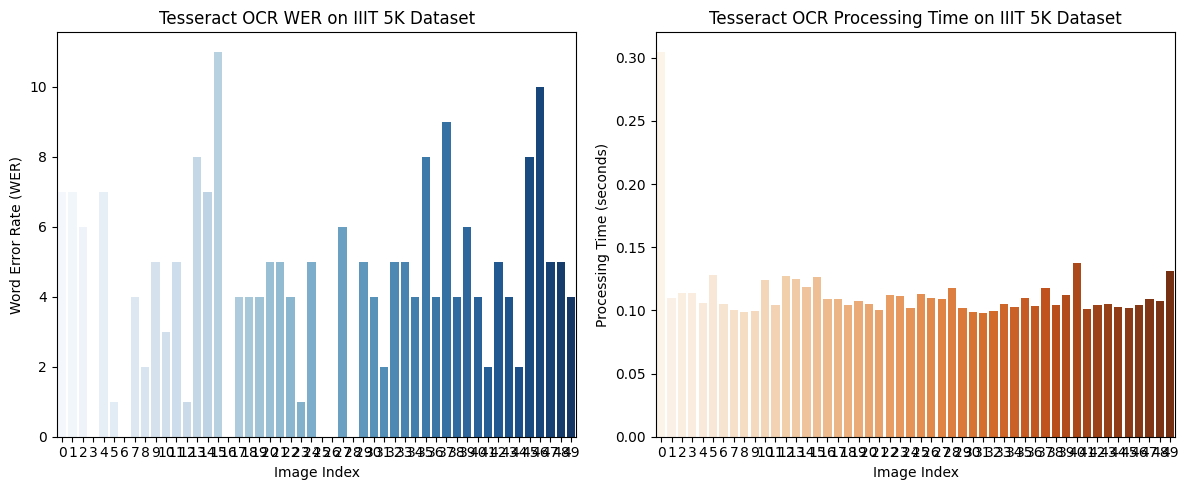

In [10]:
# Save the figure
plt.figure(figsize=(12, 5))

# WER Graph
plt.subplot(1, 2, 1)
sns.barplot(x=list(range(len(wer_scores))), y=wer_scores, palette="Blues")
plt.xlabel("Image Index")
plt.ylabel("Word Error Rate (WER)")
plt.title("Tesseract OCR WER on IIIT 5K Dataset")
plt.savefig("tesseract_wer.png")  # Save as PNG

# Processing Time Graph
plt.subplot(1, 2, 2)
sns.barplot(x=list(range(len(processing_times))), y=processing_times, palette="Oranges")
plt.xlabel("Image Index")
plt.ylabel("Processing Time (seconds)")
plt.title("Tesseract OCR Processing Time on IIIT 5K Dataset")
plt.savefig("tesseract_processing_time.png")  # Save as PNG

plt.tight_layout()
plt.show()


In [11]:
from IPython.display import FileLink

# Create download links
FileLink("tesseract_wer.png")
FileLink("tesseract_processing_time.png")


/kaggle/working/tesseract_processing_time.png

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


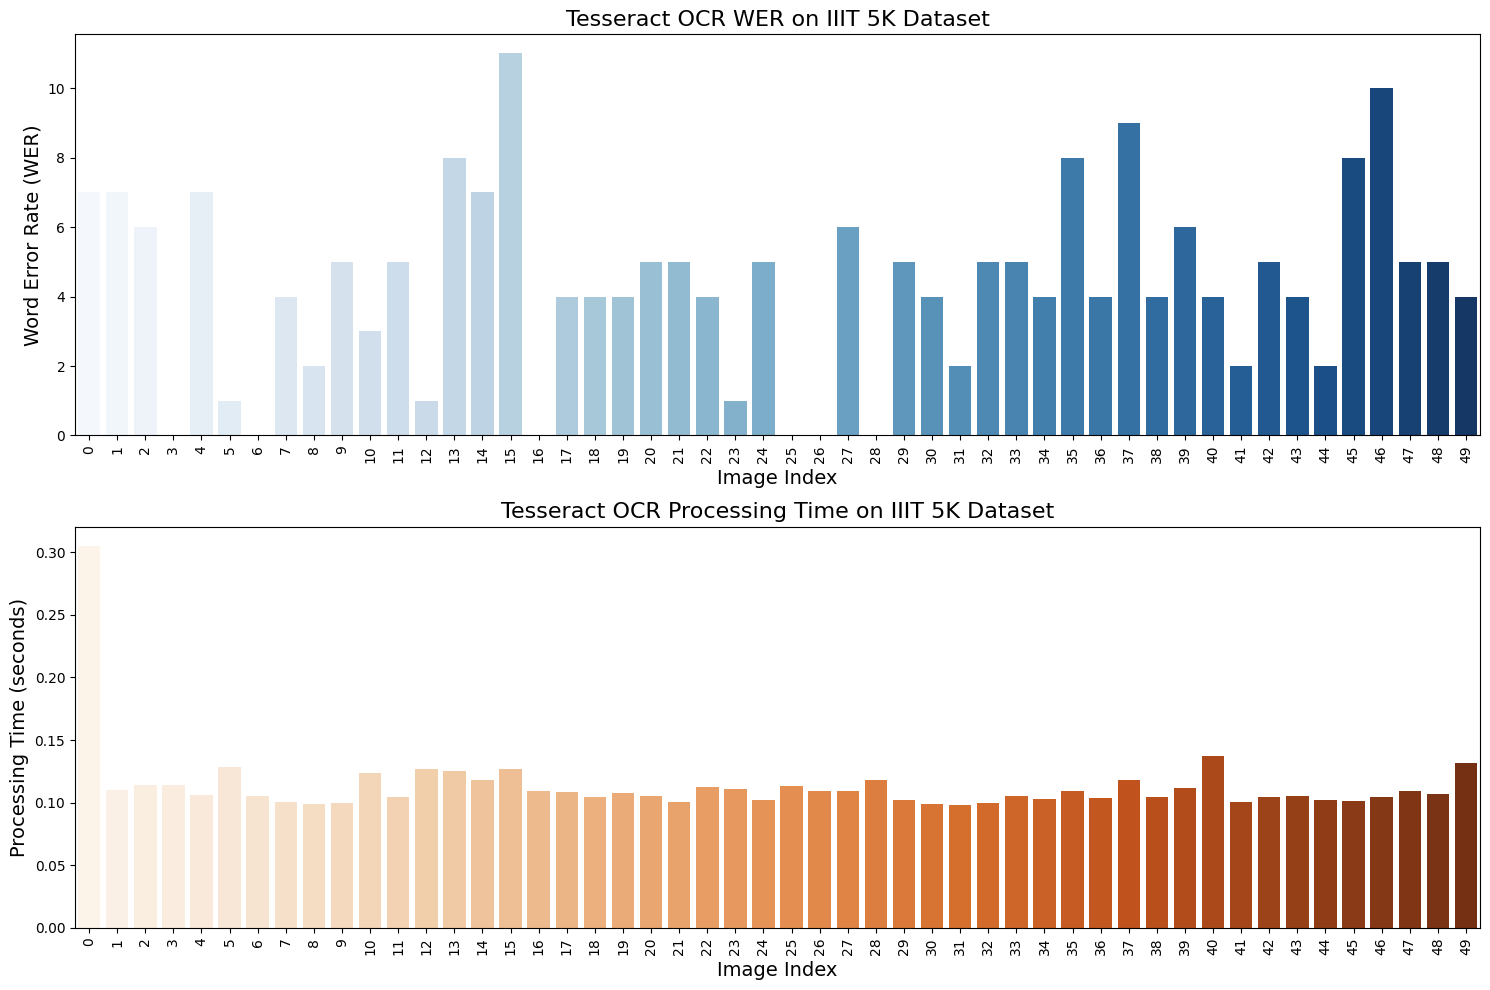

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set larger figure size for better readability
plt.figure(figsize=(15, 10))

# WER Graph (1st Plot)
plt.subplot(2, 1, 1)  # 2 rows, 1 column, first plot
sns.barplot(x=list(range(len(wer_scores))), y=wer_scores, palette="Blues")
plt.xlabel("Image Index", fontsize=14)
plt.ylabel("Word Error Rate (WER)", fontsize=14)
plt.title("Tesseract OCR WER on IIIT 5K Dataset", fontsize=16)
plt.xticks(rotation=90, fontsize=10)  # Rotate x-axis labels for better readability

# Processing Time Graph (2nd Plot)
plt.subplot(2, 1, 2)  # 2 rows, 1 column, second plot
sns.barplot(x=list(range(len(processing_times))), y=processing_times, palette="Oranges")
plt.xlabel("Image Index", fontsize=14)
plt.ylabel("Processing Time (seconds)", fontsize=14)
plt.title("Tesseract OCR Processing Time on IIIT 5K Dataset", fontsize=16)
plt.xticks(rotation=90, fontsize=10)

# Adjust layout for better spacing
plt.tight_layout()

# Save the updated figures as larger images
plt.savefig("tesseract_evaluation.png", dpi=300)  # High-resolution output

# Show the plot
plt.show()


In [13]:
from IPython.display import FileLink

# Generate download link
FileLink("tesseract_evaluation.png")


/kaggle/working/tesseract_evaluation.png